In [1]:
import os
import shutil
import random
import numpy as np

import scipy
import skimage

from matplotlib import pyplot as plt

import sklearn
import torch

%run ../metric_dissimilarity.py

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Load image metadata
images = []
with open("data/images.txt", "r") as f:
  for line in f:
    img_id, img_file = line.strip().split(" ")
    images.append((img_id, img_file))

# Load classes
classes = {}
with open("data/classes.txt", "r") as f:
  for line in f:
    cls_id, cls_name = line.strip().split(" ")
    classes[cls_name] = cls_id

# Load train/test split
train_test_split = {}
with open("data/train_test_split.txt", "r") as f:
  for line in f:
    img_id, is_train = line.strip().split(" ")
    train_test_split[img_id] = int(is_train)

# Load images
X_train = []
Y_train = []

X_test = []
Y_test = []

for (img_id, img_file) in images:
  img = skimage.io.imread(f"data/processed/{img_id}.jpg")
  cls_id = int(classes[img_file.split("/")[0]]) - 1
  if train_test_split[img_id] == 1:
    X_train.append(img)
    Y_train.append(cls_id)
  else:
    X_test.append(img)
    Y_test.append(cls_id)

# Convert to numpy
X_train = np.array(X_train, dtype = np.uint8)
Y_train = np.array(Y_train, dtype = np.int64)

X_test = np.array(X_test, dtype = np.uint8)
Y_test = np.array(Y_test, dtype = np.int64)

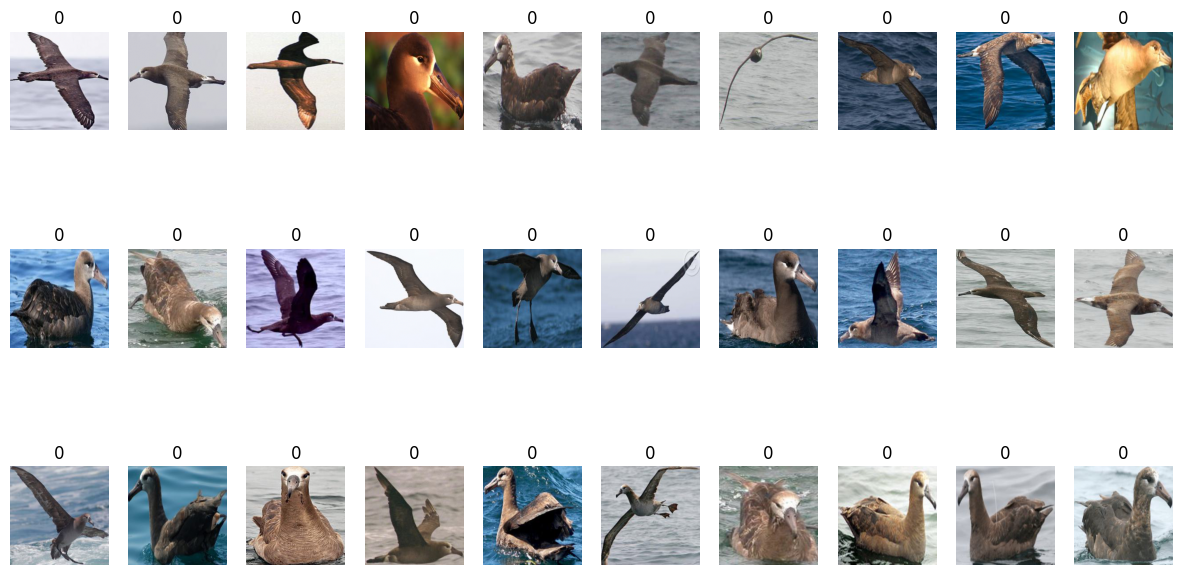

In [3]:
# Visualize some images and their corresponding labels.
plt.figure(figsize=(15, 8))
for i in range(30):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(X_train[i] / 255.)
  plt.title(Y_train[i])
  plt.axis("off")

In [ ]:
# Model training
embeddings = [64, 128, 256]
models = {}

for embedding in embeddings:

  # Base model
  models[embedding] = train(X_train, Y_train, model_type="triplet", backbone="efficientnet_v2_s",
        model_file=f"models/triplet-{embedding}.pth",
        embeddingsize=embedding, patch_size=(200,200), 
        clf_warmup=True, clf_warmup_epochs=50, clf_epochs=100,
        warmup_iterations=10000, iterations=20000,
        lr_warmup=0.01, lr=0.001,
        alpha_warmup=1.0, alpha=1.0)
  
  # Triplet mining
  if not os.path.exists(f"models/triplet-mining-{embedding}.pth"):
    # Copy the model to a new file
    # This is necessary because the triplet mining process will overwrite the model file
    # and we want to keep the original model for later use
    shutil.copyfile(f"models/triplet-{embedding}.pth", f"models/triplet-mining-{embedding}.pth")

    # Triplet mining
    for _ in range(3):
      train(X_train, Y_train, model_type="triplet", backbone="efficientnet_v2_s",
            model_file=f"models/triplet-mining-{embedding}.pth",
            embeddingsize=embedding, patch_size=(200,200), 
            triplet_mining=True, alpha=1.0, mining_iterations=5000, mining_hardness=50, mining_lr=0.001)

    for _ in range(4):
      train(X_train, Y_train, model_type="triplet", backbone="efficientnet_v2_s",
            model_file=f"models/triplet-mining-{embedding}.pth",
            embeddingsize=embedding, patch_size=(200,200), 
            triplet_mining=True, alpha=1.0, mining_iterations=2000, mining_hardness=80, mining_lr=0.001)
      
    for _ in range(5):
      train(X_train, Y_train, model_type="triplet", backbone="efficientnet_v2_s",
            model_file=f"models/triplet-mining-{embedding}.pth",
            embeddingsize=embedding, patch_size=(200,200), 
            triplet_mining=True, alpha=1.0, mining_iterations=2000, mining_hardness=90, mining_lr=0.001)
    
    # Overwrite the base model with the triplet mining model
    models[embedding] = train(X_train, Y_train, model_type="triplet", backbone="efficientnet_v2_s",
        model_file=f"models/triplet-mining-{embedding}.pth",
        embeddingsize=embedding, patch_size=(200,200))

Model file: models/triplet-64.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-128.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-256.pth
Loading pre-trained model...
Model is ready for evaluation.


In [5]:
# Embedding generation
train_embeddings = {}
test_embeddings = {}
for embedding in embeddings:
  train_embeddings[embedding] = generate_embedding(models[embedding], X_train, patch_size=(200, 200), cache=f"cache/train_embedding_{embedding}.pkl")
  test_embeddings[embedding] = generate_embedding(models[embedding], X_test, patch_size=(200, 200), cache=f"cache/test_embedding_{embedding}.pkl")

In [6]:
# Prototype generation
X_prot = {}
Y_prot = {}
for embedding in embeddings:
  X_prot[embedding] = {}
  Y_prot[embedding] = {}
  for clust in ["kmeans", "spectral", "hierarchical"]:
    X_prot[embedding][clust], Y_prot[embedding][clust] = compute_prototypes(train_embeddings[embedding], Y_train, n_prototypes=5, method=clust, cache=f"cache/prototypes_{embedding}_{clust}.pkl")

In [7]:
# Triplet dissimilarity space representation
for embedding in embeddings:
  for clust in ["kmeans", "spectral", "hierarchical"]:
    triplet_space_train = space_representation(models[embedding], train_embeddings[embedding], X_prot[embedding][clust], cache=f"cache/triplet-space-train_{embedding}_{clust}.pkl")
    triplet_space_test = space_representation(models[embedding], test_embeddings[embedding], X_prot[embedding][clust], cache=f"cache/triplet-space-test_{embedding}_{clust}.pkl")

    np.random.seed(42)

    # Train a regular classifier
    clf = sklearn.linear_model.LogisticRegression(max_iter=5000)
    clf.fit(triplet_space_train, Y_train)

    # Evaluate the classifier
    Y_pred = clf.predict(triplet_space_test)
    acc = sklearn.metrics.accuracy_score(Y_test, Y_pred)

    print(f"Accuracy for {embedding} embedding and {clust} clustering: {acc * 100:.1f}%")

Accuracy for 64 embedding and kmeans clustering: 79.0%
Accuracy for 64 embedding and spectral clustering: 79.1%
Accuracy for 64 embedding and hierarchical clustering: 79.0%
Accuracy for 128 embedding and kmeans clustering: 81.0%
Accuracy for 128 embedding and spectral clustering: 80.8%
Accuracy for 128 embedding and hierarchical clustering: 80.9%
Accuracy for 256 embedding and kmeans clustering: 82.4%
Accuracy for 256 embedding and spectral clustering: 82.4%
Accuracy for 256 embedding and hierarchical clustering: 82.4%


In [8]:
# Traditional dissimilarity space representation
for embedding in embeddings:
  for clust in ["kmeans", "spectral", "hierarchical"]:
    for dist in ["euclidean", "cosine"]:
      space_train = tradt_space_representation(train_embeddings[embedding], X_prot[embedding][clust], distance=dist, cache=f"cache/trad-space-train_{embedding}_{clust}_{dist}.pkl")
      space_test = tradt_space_representation(test_embeddings[embedding], X_prot[embedding][clust], distance=dist, cache=f"cache/trad-space-test_{embedding}_{clust}_{dist}.pkl")

      np.random.seed(42)

      # Train a regular classifier
      clf = sklearn.linear_model.LogisticRegression(max_iter=5000)
      clf.fit(space_train, Y_train)

      # Evaluate the classifier
      Y_pred = clf.predict(space_test)
      acc = sklearn.metrics.accuracy_score(Y_test, Y_pred)

      print(f"Accuracy for {embedding} embedding, {clust} clustering and {dist} distance: {acc * 100:.1f}%")

Accuracy for 64 embedding, kmeans clustering and euclidean distance: 79.6%
Accuracy for 64 embedding, kmeans clustering and cosine distance: 79.4%
Accuracy for 64 embedding, spectral clustering and euclidean distance: 79.7%
Accuracy for 64 embedding, spectral clustering and cosine distance: 79.4%
Accuracy for 64 embedding, hierarchical clustering and euclidean distance: 79.7%
Accuracy for 64 embedding, hierarchical clustering and cosine distance: 79.3%
Accuracy for 128 embedding, kmeans clustering and euclidean distance: 81.4%
Accuracy for 128 embedding, kmeans clustering and cosine distance: 81.1%
Accuracy for 128 embedding, spectral clustering and euclidean distance: 81.5%
Accuracy for 128 embedding, spectral clustering and cosine distance: 81.1%
Accuracy for 128 embedding, hierarchical clustering and euclidean distance: 81.1%
Accuracy for 128 embedding, hierarchical clustering and cosine distance: 81.1%
Accuracy for 256 embedding, kmeans clustering and euclidean distance: 82.4%
Accu

In [9]:
# Triplet dissimilarity vector representation
for embedding in embeddings:
  for clust in ["kmeans", "spectral", "hierarchical"]:
    triplet_vector_X_train, triplet_vector_Y_train = vector_representation(models[embedding], X_train, Y_train, 
                                                                           X_prot[embedding][clust], Y_prot[embedding][clust], patch_size=(200, 200),
                                                                           cache=f"cache/triplet-vector-train_{embedding}_{clust}.pkl")
    triplet_vector_X_test, _ = vector_representation(models[embedding], X_test, Y_test, 
                                                   X_prot[embedding][clust], Y_prot[embedding][clust], patch_size=(200, 200),
                                                   cache=f"cache/triplet-vector-test_{embedding}_{clust}.pkl")


    # Contrastive dissimilarity vector classification
    np.random.seed(1234)

    # Train a regular classifier
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(triplet_vector_X_train, triplet_vector_Y_train)

    Y_pred_proba = clf.predict_proba(triplet_vector_X_test)

    # Transform the binary classification back into multiclass
    Y_pred = vector_to_class(Y_pred_proba, Y_test, Y_prot[embedding][clust])

    # Evaluate the classifier
    acc = sklearn.metrics.accuracy_score(Y_test, Y_pred)

    print(f"Accuracy for {embedding} embedding and {clust} clustering: {acc * 100:.1f}%")

Accuracy for 64 embedding and kmeans clustering: 80.6%
Accuracy for 64 embedding and spectral clustering: 80.7%
Accuracy for 64 embedding and hierarchical clustering: 80.6%
Accuracy for 128 embedding and kmeans clustering: 82.2%
Accuracy for 128 embedding and spectral clustering: 82.2%
Accuracy for 128 embedding and hierarchical clustering: 82.3%
Accuracy for 256 embedding and kmeans clustering: 83.1%
Accuracy for 256 embedding and spectral clustering: 83.1%
Accuracy for 256 embedding and hierarchical clustering: 83.2%


In [10]:
# Traditional dissimilarity vector representation
for embedding in embeddings:
  for clust in ["kmeans", "spectral", "hierarchical"]:
    vector_X_train, vector_Y_train = tradt_vector_representation(train_embeddings[embedding], Y_train,
                                                                           X_prot[embedding][clust], Y_prot[embedding][clust],
                                                                           cache=False)
    vector_X_test, _ = tradt_vector_representation(test_embeddings[embedding], Y_test,
                                                   X_prot[embedding][clust], Y_prot[embedding][clust],
                                                   cache=False)

    # Contrastive dissimilarity vector classification
    np.random.seed(42)

    # Train a regular classifier
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(vector_X_train, vector_Y_train)

    Y_pred_proba = clf.predict_proba(vector_X_test)

    # Transform the binary classification back into multiclass
    Y_pred = vector_to_class(Y_pred_proba, Y_test, Y_prot[embedding][clust])

    # Evaluate the classifier
    acc = sklearn.metrics.accuracy_score(Y_test, Y_pred)

    print(f"Accuracy for {embedding} embedding and {clust} clustering: {acc * 100:.1f}%")

Accuracy for 64 embedding and kmeans clustering: 80.0%
Accuracy for 64 embedding and spectral clustering: 80.0%
Accuracy for 64 embedding and hierarchical clustering: 79.8%
Accuracy for 128 embedding and kmeans clustering: 81.5%
Accuracy for 128 embedding and spectral clustering: 81.5%
Accuracy for 128 embedding and hierarchical clustering: 81.6%
Accuracy for 256 embedding and kmeans clustering: 82.7%
Accuracy for 256 embedding and spectral clustering: 83.0%
Accuracy for 256 embedding and hierarchical clustering: 82.9%
